# Random Forest Classifier

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import wandb
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  accuracy_score
# local
from analytics.gear_vibration.data_loader import load_data
from analytics.gear_vibration.visualization import plot_confusion_matrix, plot_feature_importance
from analytics.utils import log_wandb_metrics
from analytics.gear_vibration.analysis import sliding_window_features, drop_features


In [9]:
data, df = load_data(path=Path('./data/gear_vibration'))

In [10]:
VERSION = '0.0.8'
CONFIG = {'window_size': 256, 'step_size': 128, 'version': VERSION, 'normalized': True}
model_name = f'rfc_w_{CONFIG['window_size']}_v{VERSION}'
model_path = f'models/gear_vibration/random_forest/{model_name}.pkl'
wandb.login()
wandb.init(project='iot_gear_vibration', name=model_name, id=model_name, resume='allow', config=CONFIG)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


accuracy,▁
class_report/0/f1-score,▁
class_report/0/precision,▁
class_report/0/recall,▁
class_report/0/support,▁
class_report/1/f1-score,▁
class_report/1/precision,▁
class_report/1/recall,▁
class_report/1/support,▁
class_report/2/f1-score,▁
class_report/2/precision,▁


In [11]:
X, true_labels = sliding_window_features(df, CONFIG['window_size'], CONFIG['step_size'])
y, fault_code = pd.factorize(true_labels['fault'])
drop_features(df=X, threshold=0.95)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_features = X.shape[1]

Number of correlated features: 3
Correlated features: {'sensor2_ptp', 'sensor2_rms', 'sensor1_rms'}

Highly correlated feature pairs:
sensor1_rms and sensor1_mean: 1.00
sensor2_rms and sensor2_mean: 1.00
sensor2_ptp and sensor2_std: 0.96
Drop highly correlated features!


In [12]:
rfc_settings = {
    'oob_score': True,
    'max_features': np.sqrt(n_features) / n_features,
    'random_state': 1,
    'n_estimators': 200
}
rfc = RandomForestClassifier().set_params(**rfc_settings)

Accuracy: 0.9829059829059829
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       0.99      1.00      0.99       247
           2       0.96      0.95      0.95       227
           3       1.00      1.00      1.00       234
           4       0.95      0.96      0.96       223
           5       1.00      1.00      1.00       232

    accuracy                           0.98      1404
   macro avg       0.98      0.98      0.98      1404
weighted avg       0.98      0.98      0.98      1404

accuracy: 0.9829
precision_macro: 0.9824
recall_macro: 0.9824
f1_macro: 0.9824
precision_weighted: 0.9829
recall_weighted: 0.9829
f1_weighted: 0.9829


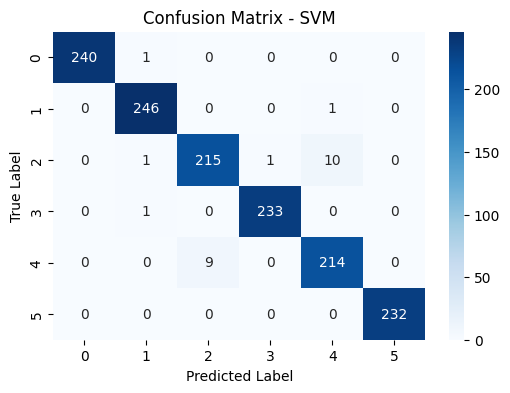

In [ ]:
rfc.fit(X_train, y_train)
joblib.dump(rfc, model_path)
artifact = wandb.Artifact(
  name=model_name,
  type='model',
  description='SVM model for gear vibration classification',
  metadata={**CONFIG, **rfc_settings}
)
artifact.add_file(model_path)
wandb.log_artifact(artifact)
# Evaluate the model
y_pred = rfc.predict(X_test)
metrics = log_wandb_metrics(y_test, y_pred)
for k, v in metrics.items():
  print(f'{k}: {v:.4f}')

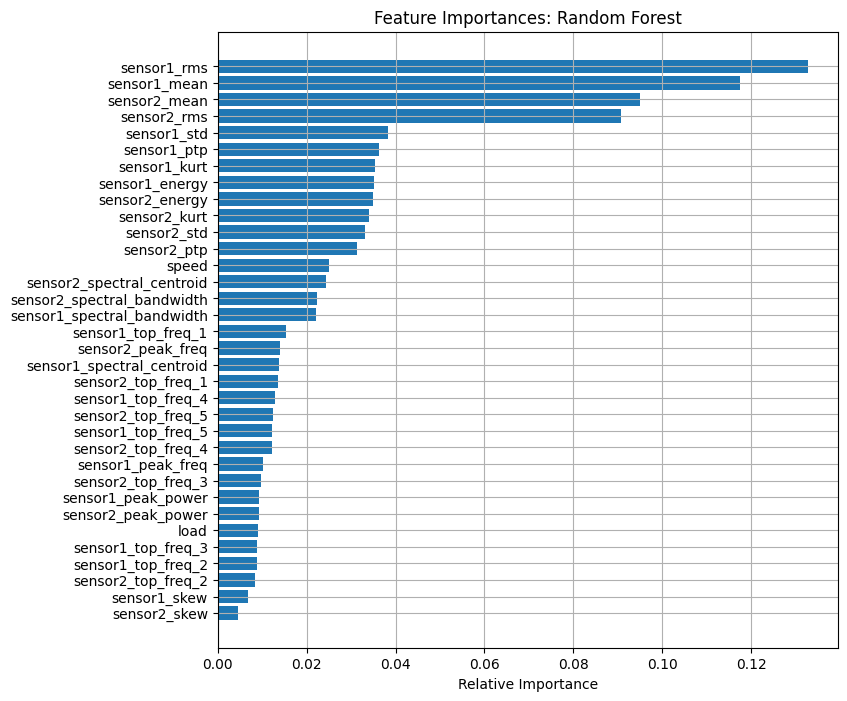

In [15]:
importance = rfc.feature_importances_
features = X.columns.values
# Sort by importance
plot_feature_importance(importance=importance, features=features, model_name='Random Forest')
wandb.log({'feature_importance': wandb.Image(plt)})